# Project: How does the fertility rate evolve? Can we find some contributing factors?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This analysis aims at exploring the dataset `tfr-by-gapminder.csv` created by Gapminder from UN estimates.
> This dataset puts together the fertility rates of women per country over almost 200 years.
> V12 of the GD008 file is used.

> In order to investigate potential correlations with region, GDP or religion, this dataset will be complemented by:
- V27 of GD001 file `gdppercapita.csv`, available on Gapminder website,
- `Religious_Composition_by_Country.csv` published by PewResearch on 2015, listed as a source of Gapminder, and available here https://www.pewforum.org/2015/04/02/religious-projection-table/2010/number/all/

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Let's start by loading and investigating all datasets

In [50]:
fertility = pd.read_csv('tfr-by-gapminder.csv', encoding='latin-1')
gdp = pd.read_csv('gdppercapita.csv', encoding='latin-1')
religion = pd.read_csv('Religious_Composition_by_Country.csv', encoding='latin-1')

In [51]:
fertility.head(2)

,geo.name,indicator.name,geo,indicator,1800,1801,1802,1803,1804,1805,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Abkhazia,Total fertility rate,abkh,tfr,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Total fertility rate,afg,tfr,7.0,7.0,7.0,7.0,7.0,7.0,...,1.74,1.74,1.74,1.74,1.74,1.74,1.74,1.74,1.74,1.74


In [52]:
fertility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Columns: 305 entries, geo.name to 2100
dtypes: float64(301), object(4)
memory usage: 655.4+ KB


In [53]:
fertility.duplicated().sum()

0

This dataset puts together numbers for **275 countries** over **301 years**.
<br>In order to find potential correlations with other factors, this timeframe and list of countries could be reduced down to be more specific.
<br>Let's explore the dataset we have for the GDP

In [54]:
gdp.head(2)

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.5k,24.2k,23.8k,24.6k,24.6k,25.8k,26.2k,26.6k,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,543,529,576,588,584,574,571,572,568,571


In [55]:
gdp['2015'].head(5)

0    25.8k
1      574
2     3750
3     4520
4    42.1k
Name: 2015, dtype: object

In [56]:
gdp.duplicated().sum()

0

We can see that the timeframe in this dataset covers from 1960 to 2019 for a list of 206 countries.
In order to find a potential correlation between fertility and GDP, we will therefore have to:
- reduce down the list of countries to those which have both data for fertility and GDP
- reduce the timeframe from 1960 to 2019

We can also see that every values are string values, for which we will have to:
- parse to transform the **'k'** into thousands
- change into float

Let's see the last dataset referring to the religion

In [57]:
religion.head(2)

,row_number,level,Nation_fk,Year,Region,Country,All Religions,Buddhists,Christians,Folk Religions,Hindus,Jews,Muslims,Other Religions,Unaffiliated
0,1,3,10000,2010,World,All Countries,100,7.1,31.4,5.9,15.0,< 1.0,23.2,< 1.0,16.4
1,2,2,1001,2010,North America,All Countries,100,1.1,77.4,< 1.0,< 1.0,1.8,1.0,< 1.0,17.1


In [58]:
religion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
row_number         1205 non-null int64
level              1205 non-null int64
Nation_fk          1205 non-null int64
Year               1205 non-null int64
Region             1205 non-null object
Country            1205 non-null object
All Religions      1205 non-null object
Buddhists          1205 non-null object
Christians         1205 non-null object
Folk Religions     1205 non-null object
Hindus             1205 non-null object
Jews               1205 non-null object
Muslims            1205 non-null object
Other Religions    1205 non-null object
Unaffiliated       1205 non-null object
dtypes: int64(4), object(11)
memory usage: 141.3+ KB


In [59]:
religion['Year'].value_counts()

2040    241
2030    241
2020    241
2010    241
2050    241
Name: Year, dtype: int64

In [60]:
religion['Christians'].head(10)

0     31.4
1     77.4
2     90.0
3     74.5
4      3.7
5     62.9
6      7.1
7    < 1.0
8     18.0
9    < 1.0
Name: Christians, dtype: object

In [61]:
religion.duplicated().sum()

0

This dataset enables to group countries per region, and analyze whether there are some regional trends on the fertility rates.
<br>5 years of data are included: we will retain only 1 year (2020) as we do not need to investigate the impact of the evolution of religion within a country on the fertility rate
<br>Finally, the distribution of religion in each country is given as a string that we will have to convert into floats after taking care of the **'<'** and **'>'** symbols.

### Data Cleaning

Let's start by cleaning the columns of the `fertility` dataset, and creating a reduced copy for exploration of GDP correlation

In [62]:
fertility.rename(columns={'geo.name':'Country'},inplace=True)

# remove unecessary columns
fertility = fertility.drop(['indicator.name','geo','indicator'], axis=1)

# Create a list of the columns we want to retain for the correlation analysis
columns = [str(x) for x in range(1960,2020)]
columns.insert(0,'Country')

fertility_sub = fertility[columns]
fertility_sub.head()

,Country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,...,5.82,5.60,5.38,5.17,4.98,4.80,4.64,4.48,4.33,4.18
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,6.49,6.40,6.28,6.13,5.96,5.77,5.58,5.39,5.22,...,1.65,1.67,1.69,1.70,1.71,1.71,1.71,1.71,1.71,1.70
4,Algeria,7.52,7.57,7.61,7.65,7.67,7.68,7.68,7.67,7.67,...,2.89,2.93,2.94,2.92,2.89,2.84,2.78,2.71,2.64,2.59


Let's now clean the `gdp` dataset.
We need to convert the **'k'** symbol into thousands, and convert the result into integer

In [63]:
for col in gdp.columns:
    if col != 'country':
        gdp[col] = gdp[col].str.replace('k','00')
        gdp[col] = gdp[col].str.replace('.','')
        # some values within the column are NaN, reason why I use the 'coerce' method
        gdp[col] = pd.to_numeric(gdp[col], errors='coerce')
        gdp[col] = gdp[col].replace('nan',np.nan)
gdp.head()

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23500,24200.0,23800.0,24600.0,24600.0,25800.0,26200.0,26600.0,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,543,529.0,576.0,588.0,584.0,574.0,571.0,572.0,568.0,571.0
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3590,3580.0,3750.0,3800.0,3840.0,3750.0,3530.0,3410.0,3230.0,3100.0
3,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4090,4210.0,4280.0,4330.0,4410.0,4520.0,4680.0,4860.0,5070.0,5210.0
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40900,41200.0,39800.0,39100.0,40900.0,42100.0,44100.0,44400.0,45100.0,45900.0


Let's now clean the `religion` dataset.
<br>We will first retain only the data for 2020.
<br>We also need to convert the cells with a **'<'** symbol into 0, those with **'>'** into 100, and convert the result into integer.
<br>Then, the idea would be to retain for each country only the most prevailing religion. Even if the results of potential correlation with fertility rate should be refined or weighted by the ratio of this religion among the others in a given country, let's start with this easier approach. 

Clean the data

In [64]:
# retain only 2020 data
religion = religion[religion['Year']==2020]
# retain only the columns we need
religion = religion.drop(['row_number','level','Nation_fk','Year'], axis=1)
# parse the data to remove the symbols
religion.replace('< 1.0','0',inplace=True)
religion.replace('>99.0','100',inplace=True)
religion.head()

,Region,Country,All Religions,Buddhists,Christians,Folk Religions,Hindus,Jews,Muslims,Other Religions,Unaffiliated
241,World,All Countries,****,6.6,31.1,5.6,15.2,0,24.9,0,15.6
242,North America,All Countries,100,1.2,74.6,0,0,1.6,1.3,0,19.2
243,Latin America-Caribbean,All Countries,100,0,89.7,1.8,0,0,0,0,8.0
244,Europe,All Countries,100,0,72.2,0,0,0,6.8,0,20.0
245,Middle East-North Africa,All Countries,100,0,3.6,0,0,1.6,93.1,0,0


Determine the most prevailing religion

In [65]:
# create a subset with only the different religions
religion_subset = religion.iloc[:,3:11]
# get the max prevailing religion
religion['first_religion']=religion_subset.idxmax(axis='columns')
religion.head()

,Region,Country,All Religions,Buddhists,Christians,Folk Religions,Hindus,Jews,Muslims,Other Religions,Unaffiliated,first_religion
241,World,All Countries,****,6.6,31.1,5.6,15.2,0,24.9,0,15.6,Christians
242,North America,All Countries,100,1.2,74.6,0,0,1.6,1.3,0,19.2,Christians
243,Latin America-Caribbean,All Countries,100,0,89.7,1.8,0,0,0,0,8.0,Christians
244,Europe,All Countries,100,0,72.2,0,0,0,6.8,0,20.0,Christians
245,Middle East-North Africa,All Countries,100,0,3.6,0,0,1.6,93.1,0,0,Muslims


<a id='eda'></a>
## Exploratory Data Analysis

### How does the mean fertility rate evolve?

Let's plot the evolution of the mean global fertility rate and include some key points in the chart.
<br> Knowing we will have several plots to do, we will create a function `cust_plot` that will take graph titles for inputs and customize the size of charts

In [66]:
def cust_plot(title_x,title_y,title_chart):
    figure(figsize=(8, 6), dpi=80)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_chart)
    plt.grid()

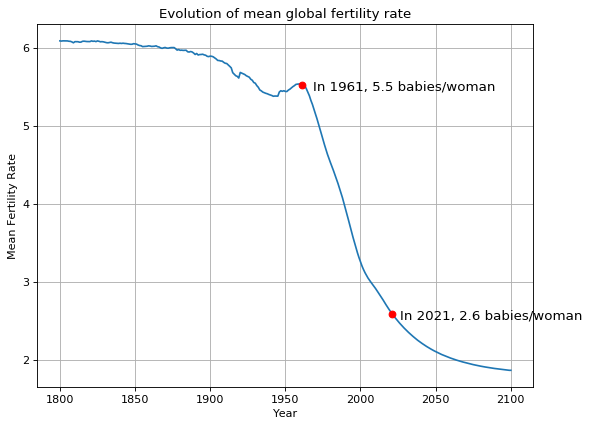

In [67]:
cust_plot('Year','Mean Fertility Rate','Evolution of mean global fertility rate')
plt.plot(fertility.columns[1:], fertility.mean())

plt.plot(1961,fertility['1961'].mean(), "or")
plt.annotate("In 1961, "+str(round(fertility['1961'].mean(),1))+" babies/woman", (1961, fertility['1961'].mean()),xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12)
plt.plot(2021,fertility['2021'].mean(), "or")
plt.annotate("In 2021, "+str(round(fertility['2021'].mean(),1))+" babies/woman", (2019, fertility['2021'].mean()),xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12);

We can see that the mean global fertility rate abruptally drops from **5.5 babies per woman** in 1961, down to **2.6 babies per woman** in 2021.

### Are there regional trends in the evolution of the fertility rate?

Let's see if there are some regional trends by adding curves relative to each region.
<br>To do so, we must first join the `fertility` dataset with the `religion` dataset to associate a country to its region

In [68]:
fertility_enriched = pd.merge(fertility, religion, on='Country', how='left')
fertility_enriched = fertility_enriched.drop(fertility_enriched.columns[-10:-1], axis=1)
fertility_enriched.head()

,Country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2093,2094,2095,2096,2097,2098,2099,2100,Region,first_religion
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,...,1.74,1.74,1.74,1.74,1.74,1.74,1.74,1.74,Asia-Pacific,Muslims
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,4.60,4.60,4.60,4.60,4.60,4.60,4.60,4.60,4.60,...,1.78,1.79,1.79,1.79,1.79,1.79,1.79,1.79,Europe,Muslims
4,Algeria,6.99,6.99,6.99,6.99,6.99,6.99,6.99,6.99,6.99,...,1.86,1.86,1.86,1.86,1.86,1.86,1.86,1.86,Middle East-North Africa,Muslims


Let's explore our new `fertility_enriched` dataset

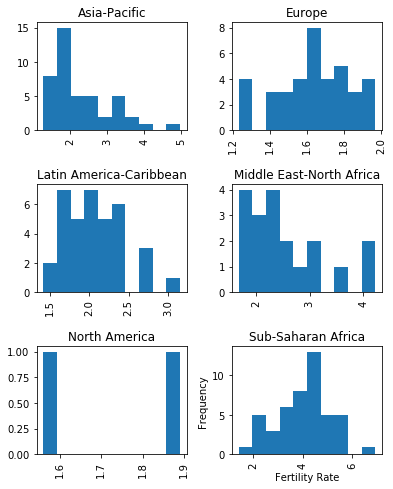

In [69]:
fertility_enriched['2021'].hist(by=fertility_enriched['Region'],figsize = (6,8));
plt.xlabel('Fertility Rate')
plt.ylabel('Frequency');

2019
Region                                 
Asia-Pacific             mean  2.370455
                         std   0.865375
Europe                   mean  1.629211
                         std   0.201674
Latin America-Caribbean  mean  2.110278
                         std   0.398809
Middle East-North Africa mean  2.622105
                         std   0.784358
North America            mean  1.730000
                         std   0.240416
Sub-Saharan Africa       mean  4.177660
                         std   1.142966

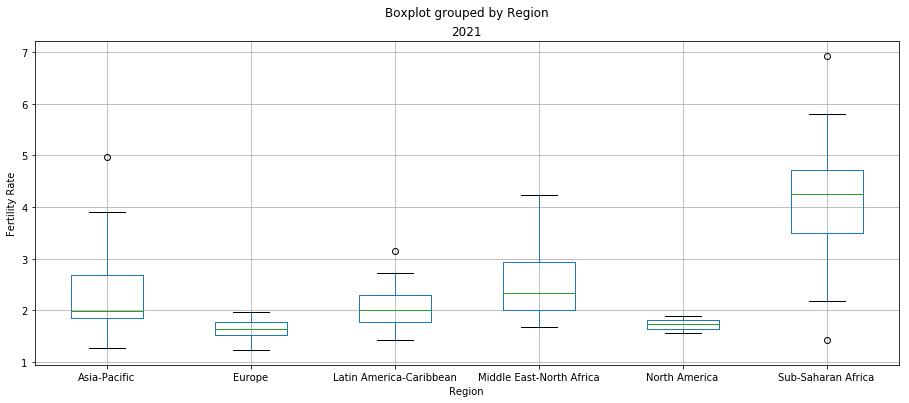

In [70]:
fertility_enriched.boxplot(column=['2021'], by=['Region'], figsize=(15,6))
plt.ylabel('Fertility Rate')
plt.xlabel('Region');
pd.DataFrame(fertility_enriched.groupby(['Region'])['2019'].describe().loc[:,['mean','std']])

We can see a small range of data for Europe and North America, whereas data for Asia-Pacific and Sub-Saharan Africa is much more spread, with outliers.
<br>Let's have a look at the number of countries in each region to see if these ranges can be explained.

In [71]:
fertility_enriched.groupby(['Region'])[['2021']].count()

,2021
Region,
Asia-Pacific,44
Europe,38
Latin America-Caribbean,36
Middle East-North Africa,19
North America,2
Sub-Saharan Africa,47


Only 2 countries are in North America, which explains the reduced range of data for this region.
<br>But Europe has 38 countries, with a standard deviation of 0.2: the distribution seems to be symetrical and really close to the average value 

We can now analyze the regional trends

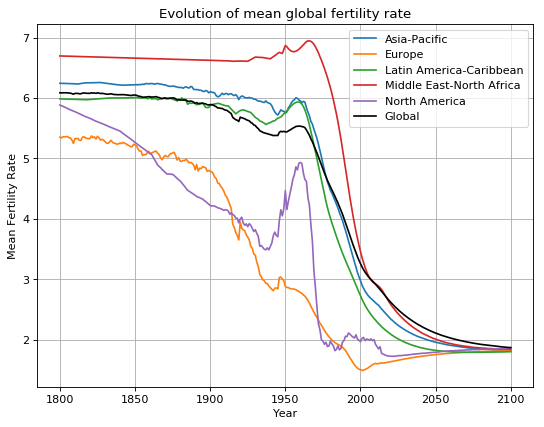

In [72]:
fertility_region = fertility_enriched.groupby('Region').mean()

cust_plot('Year','Mean Fertility Rate','Evolution of mean global fertility rate')

for row in range(len(fertility_region)-1):
    plt.plot(list(fertility_region.columns), fertility_region.iloc[row,:])

plt.plot(fertility.columns[1:], fertility.mean(), 'k-', label='Global')

plt.legend(loc='upper right');

We can see that, of all the regions available, Asia, Latin America and Middle East fertility rates follow the same trend as the mean global fertility rate.
<br>Europe follows also the same trend, but started almost 60 years before.
<br>And North America has a complete different trend, decreasing steadily from 1800, with an abrupt bounce back in 1960.

### Are there trends linked to religion in the evolution of the fertility rate?

Since we already joined the `fertility` dataset with the `religion` dataset, let's analyse the trend of each religion on the fertility rate.
<br>To do that, we will use the `groupby` function

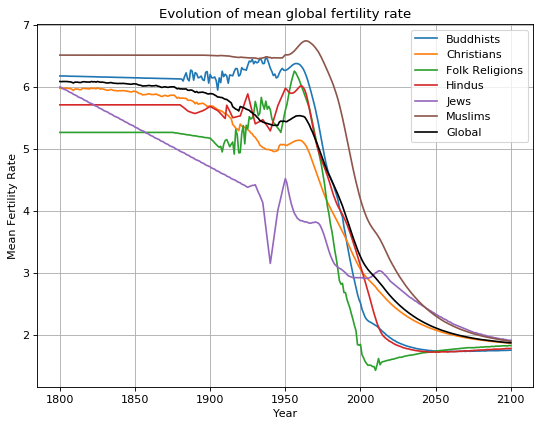

In [73]:
fertility_religion = fertility_enriched.groupby('first_religion').mean()

cust_plot('Year','Mean Fertility Rate','Evolution of mean global fertility rate')

for row in range(len(fertility_religion)-1):
    plt.plot(list(fertility_religion.columns), fertility_religion.iloc[row,:])

plt.plot(fertility.columns[1:], fertility.mean(), 'k-', label='Global')
    
plt.legend(loc='upper right');

We can disregard the countries mostly Jewish, as the shape of the curve seems to indicate rather limited data available.
<br>Christian countries follow the same trend as the global one, but countries with other religions experienced an increase of fertility rate before 1960.
<br>It is also interesting to see that countries that are declared as 'Folk Religions' had an abrupt rise of fertility rate between 1900 and 1960, before following the same trend as the global fertility rate.

### Is there a correlation between GDP and fertility rate?

Let's see now if we can find a correlation between the GDP and the fertility rate.

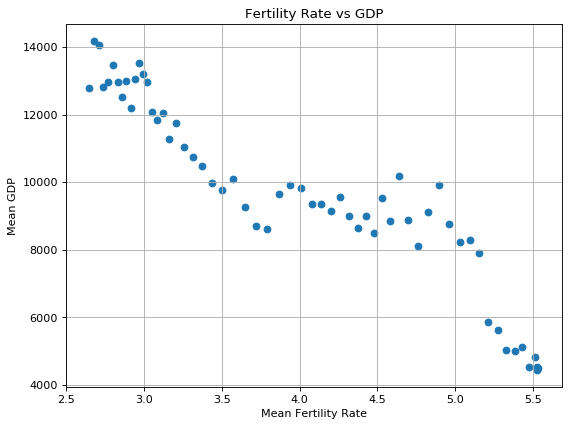

In [74]:
cust_plot('Mean Fertility Rate','Mean GDP','Fertility Rate vs GDP')

plt.scatter(fertility_sub.mean(), gdp.mean());

We can see a negative correlation between the fertility rate and the GDP: the more the GDP of a country, the less fertility rate it has

<a id='conclusions'></a>
## Conclusions

>In this report, we first analyzed the evolution of the mean global fertility rate: the mean number of babies per woman dropped drastically from the 1960's.


>Analyzing the variation for different regions, we saw that all available regions follow the same trend, with the exception of:
- Europe that started its decline of mean fertility rate 60 years before the global one
- North America that had a sharp decline from 1800, but bounced back in 1960 before following the same trend as the global
Note that Australia, Africa and South America are not explicit regions considered in this study

>Analyzing the religion trends, countries mostly Christians follow the exact same trend than the global one. Countries with 'folk religion' experienced a sharp increase before the decrease of 1960.
<br>It is important to remember that only the most prevailing religion is retained for each country, which means the religions of each country have not been weighted by their distribution.
<br>Moreover, the data for unaffiliated, even though they are numbered in the dataset, never shows up as the most prevailing condition for religion.

>Finally, we found a strong correlation between GDP and fertility rate: the wealthier the country, the fewer babies women have.


##### I used the stackoverflow website to find tricks to help me in building my code